In [2]:
import os
import sys

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data.fetcher import get_single_ticker
from src.data.features import FeatureEngineer
from src.models.baseline import OLSModel
from src.evaluation.backtest import backtest_signals

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.grid"] = True

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

In [3]:
start_date = "2015-01-01"
end_date = "2024-01-01"

spy = get_single_ticker("SPY", start=start_date, end=end_date, use_cache=True)

print(spy.head())
print(spy.tail())
print(f"\nShape : {spy.shape}")

Attempting to load from cache...
Cache not found. Downloading...
Fetching data for SPY...
✓ Data for SPY cached at data/raw/SPY_1d.csv.
             adj_close       close        high         low        open     volume
date                                                                             
2015-01-02  171.093704  205.429993  206.880005  204.179993  206.380005  121465900
2015-01-05  168.003784  201.720001  204.369995  201.350006  204.169998  169632600
2015-01-06  166.421387  199.820007  202.720001  198.860001  202.089996  209151400
2015-01-07  168.495193  202.309998  202.720001  200.880005  201.419998  125346700
2015-01-08  171.485138  205.899994  206.160004  203.990005  204.009995  147217800
             adj_close       close        high         low        open     volume
date                                                                             
2023-12-22  463.589142  473.649994  475.380005  471.700012  473.859985   67160400
2023-12-26  465.546692  475.649994  476.5799

In [4]:
engineer = FeatureEngineer()

features_df = engineer.create_all_features(spy)

print("\nColumns avaliable :")
print(features_df.columns.tolist())

print("\nData overview with features")
features_df.head()

Creating features...
Returns added
Momentum added
Volatility added
RSI added
Volume features added
Target created

Columns avaliable :
['adj_close', 'close', 'high', 'low', 'open', 'volume', 'return_1d', 'log_return_1d', 'return_5d', 'log_return_5d', 'return_20d', 'log_return_20d', 'sma_20d', 'price_to_sma_20', 'sma_50d', 'price_to_sma_50', 'ma_cross_20_50', 'volatility_20d', 'hl_range_20d', 'rsi_14', 'volume_ma_20', 'volume_ratio_20', 'target_return_1d', 'target_direction_1d']

Data overview with features


,adj_close,close,high,low,open,volume,return_1d,log_return_1d,return_5d,log_return_5d,return_20d,log_return_20d,sma_20d,price_to_sma_20,sma_50d,price_to_sma_50,ma_cross_20_50,volatility_20d,hl_range_20d,rsi_14,volume_ma_20,volume_ratio_20,target_return_1d,target_direction_1d
date,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,171.093704,205.429993,206.880005,204.179993,206.380005,121465900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018060,0
2015-01-05,168.003784,201.720001,204.369995,201.350006,204.169998,169632600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009419,0
2015-01-06,166.421387,199.820007,202.720001,198.860001,202.089996,209151400,-0.018060,-0.018225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012461,1
2015-01-07,168.495193,202.309998,202.720001,200.880005,201.419998,125346700,-0.009419,-0.009464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017745,1
2015-01-08,171.485138,205.899994,206.160004,203.990005,204.009995,147217800,0.012461,0.012384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008014,0


In [5]:
target_col = "target_return_1d"

candidate_features = [
    "return_1d",
    "return_5d",
    "return_20d",
    "log_return_1d",
    "price_to_sma_20d",
    "price_to_sma_50d",
    "volatility_20d",
    "rsi_14",
    "vix",
    "excess_return_1d"
]

feature_cols = [c for c in candidate_features if c in features_df.columns]

print("Selected features :")
print(feature_cols)

df_model = features_df.dropna(subset=[target_col] + feature_cols).copy()

X = df_model[feature_cols]
y = df_model[target_col]

print(f"Final size of dataset model : {X.shape[0]} observations, {X.shape[1]} features")

Selected features :
['return_1d', 'return_5d', 'return_20d', 'log_return_1d', 'volatility_20d', 'rsi_14']
Final size of dataset model : 2242 observations, 6 features


In [6]:
split_date = "2020-01-01"

X_train = X[X.index < split_date]
y_train = y[y.index < split_date]

X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

print(f"train : {X_train.index.min().date} -> {X_train.index.max().date()} ({len(X_train)} obs)")
print(f"test : {X_test.index.min().date} -> {X_test.index.max().date()} ({len(X_test)} obs)")

train : <bound method Timestamp.date of Timestamp('2015-02-03 00:00:00')> -> 2019-12-31 (1237 obs)
test : <bound method Timestamp.date of Timestamp('2020-01-02 00:00:00')> -> 2023-12-28 (1005 obs)


In [7]:
ols = OLSModel(use_hac=True, maxlags=5)
ols.fit(X_train, y_train, add_constant=True, standardize=False)

ols.summary()

coef_df = ols.get_coefficients()
coef_df

OLS Regression Results
                            OLS Regression Results                            
Dep. Variable:       target_return_1d   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.067
Date:                Sun, 23 Nov 2025   Prob (F-statistic):              0.380
Time:                        15:57:36   Log-Likelihood:                 4152.9
No. Observations:                1237   AIC:                            -8292.
Df Residuals:                    1230   BIC:                            -8256.
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.

,coefficient,std_error,t_statistic,p_value,ci_lower,ci_upper,significance
const,0.000904,0.001454,0.621433,0.534314,-0.001947,0.003754,
return_1d,4.361813,4.236424,1.029598,0.303199,-3.941425,12.665050,
return_5d,-0.004134,0.026250,-0.157475,0.874870,-0.055583,0.047315,
return_20d,0.012692,0.012330,1.029428,0.303278,-0.011473,0.036858,
log_return_1d,-4.403400,4.245681,-1.037148,0.299667,-12.724781,3.917981,
volatility_20d,0.003996,0.005101,0.783367,0.433412,-0.006002,0.013994,
rsi_14,-0.000021,0.000021,-1.008914,0.313016,-0.000063,0.000020,


In [8]:
y_pred_test = ols.predict(X_test)

predictions = pd.Series(y_pred_test, index=X_test.index, name="y_pred")

print("Predictions overview :")
predictions.head()

signals = (predictions > 0).astype(int)
signals.name = "signal"

print("Signal distribution :")
print(signals.value_counts(normalize=True))
signals.head()

Predictions overview :
Signal distribution :
signal
1    0.917413
0    0.082587
Name: proportion, dtype: float64


date
2020-01-02    0
2020-01-03    0
2020-01-06    1
2020-01-07    1
2020-01-08    1
Name: signal, dtype: int64

In [10]:
bt = backtest_signals(
    returns=y_test,
    signals=signals,
    trading_cost_bps=1.0,
    starting_capital=1.0,
)
print("stats performance :")
for k, v in bt.stats.items():
    print(f"{k:25s}: {v:.4f}" if isinstance(v, (int, float)) and not np.isnan(v) else f"{k:25s}: {v}")

stats performance :
strategy_total_return    : 0.6034
strategy_annual_return   : 0.1542
strategy_annual_vol      : 0.2232
strategy_sharpe          : 0.6909
strategy_max_drawdown    : -0.3238
strategy_hit_rate        : 0.5108
strategy_avg_gain        : 0.0097
strategy_avg_loss        : -0.0089
strategy_n_trades        : 971.0000
benchmark_total_return   : 0.4631
benchmark_annual_return  : 0.1290
benchmark_annual_vol     : 0.2271
benchmark_sharpe         : 0.5680
benchmark_max_drawdown   : -0.3410
benchmark_hit_rate       : 0.5374
benchmark_avg_gain       : 0.0094
benchmark_avg_loss       : -0.0098
benchmark_n_trades       : 1003.0000


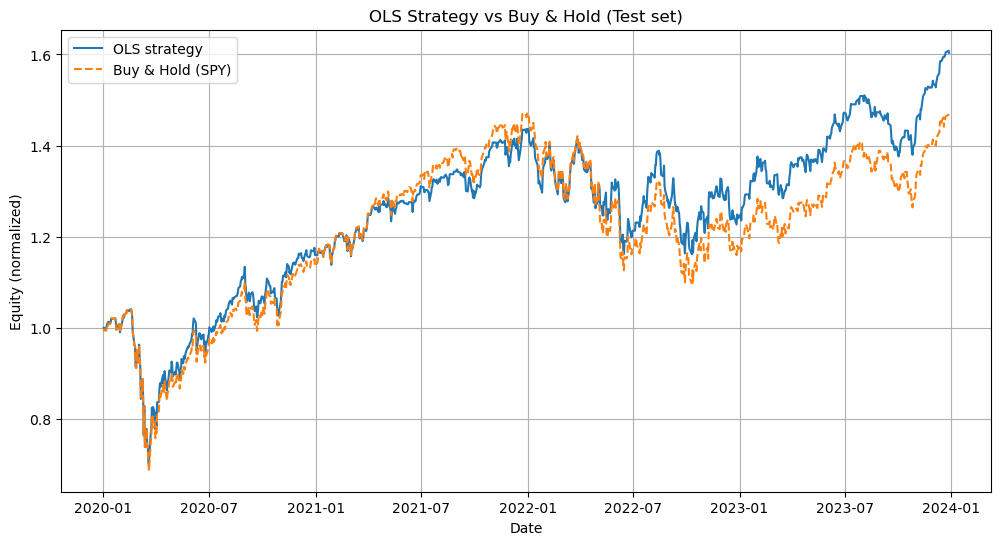

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(bt.equity_curve, label="OLS strategy")
plt.plot(bt.benchmark_curve, label="Buy & Hold (SPY)", linestyle="--")
plt.title("OLS Strategy vs Buy & Hold (Test set)")
plt.xlabel("Date")
plt.ylabel("Equity (normalized)")
plt.legend()
plt.show()

Daily stats (test set) :

Strategy :
count    1005.000000
mean        0.000569
std         0.014058
min        -0.109424
25%        -0.005083
50%         0.000000
75%         0.007429
max         0.090503
dtype: float64

Benchmark :
count    1005.000000
mean        0.000482
std         0.014306
min        -0.109424
25%        -0.006096
50%         0.000786
75%         0.007649
max         0.090603
Name: returns, dtype: float64


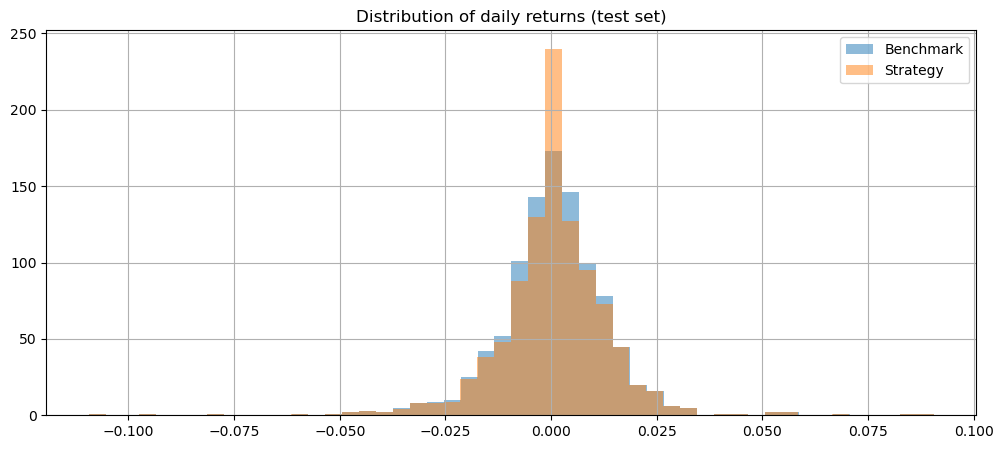

In [12]:
bt_returns = bt.strategy_returns
bench_returns = bt.benchmark_returns

print("Daily stats (test set) :")
print("\nStrategy :")
print(bt_returns.describe())

print("\nBenchmark :")
print(bench_returns.describe())

plt.figure(figsize=(12,5))
plt.hist(bench_returns, bins=50, alpha=0.5, label="Benchmark")
plt.hist(bt_returns, bins=50, alpha=0.5, label="Strategy")
plt.legend()
plt.title("Distribution of daily returns (test set)")
plt.show()
